In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.sql import functions
from pyspark.sql.functions import udf, isnan, when, count, col, date_sub,next_day, mean, year, month, date_format
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.mllib.stat import Statistics

In [2]:
spark_application_name = "Spark_Project"
spark = (SparkSession.builder.appName(spark_application_name).getOrCreate())

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/19 21:35:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
stocks_path = 'stocks_data/MICROSOFT.csv'
another_sck_path = 'stocks_data/AMAZON.csv'

In [4]:
def get_data(path, schema, header=True, delimiter=';'):
    """Lire les données à partir d'un path.

    Parameters
    ----------
    path : string
        Le chemin du fichier
    schema : StructType
        Le schema appliqué sur le dataframe
    header: bool
        Le boolean qui indique l'utilisation de la première ligne comme noms de colonnes. True par défaut
    delimiter: 
        Définit un séparateur pour chaque champ et chaque valeur. ; par défaut
    Returns
    -------
    DataFrame
        Le DataFrame du fichier
    """
    
    extension = path.split('.')[-1]
    if (extension == "csv"):
        df = spark.read.csv(path, schema, header=header, sep=delimiter)
    elif (extension == 'json'):
        df = spark.read.json(path, schema)
    else:
        # join all csv in a folder
        df = spark.read.csv(path, schema, header=header, sep=delimiter)
    return df

In [5]:
# Define schema
stocksColumns = [StructField("Date",TimestampType()), StructField("High",DoubleType()), 
              StructField("Low",DoubleType()), StructField("Open",DoubleType()),
              StructField("Close",DoubleType()), StructField("Volume", DoubleType()), 
              StructField("Adj Close",DoubleType()), StructField("company_name", StringType())]

stocksSchema = StructType(stocksColumns)


df = get_data(stocks_path, stocksSchema, delimiter=',')
df.show()

+-------------------+------------------+------------------+------------------+------------------+---------+------------------+------------+
|               Date|              High|               Low|              Open|             Close|   Volume|         Adj Close|company_name|
+-------------------+------------------+------------------+------------------+------------------+---------+------------------+------------+
|2017-01-03 00:00:00| 62.84000015258789|62.130001068115234|62.790000915527344| 62.58000183105469|2.06941E7| 58.67324447631836|   MICROSOFT|
|2017-01-04 00:00:00|             62.75|62.119998931884766| 62.47999954223633| 62.29999923706055|  2.134E7| 58.41072463989258|   MICROSOFT|
|2017-01-05 00:00:00| 62.65999984741211|62.029998779296875|62.189998626708984| 62.29999923706055| 2.4876E7| 58.41072463989258|   MICROSOFT|
|2017-01-06 00:00:00|63.150001525878906|62.040000915527344| 62.29999923706055| 62.84000015258789|1.99229E7|58.917015075683594|   MICROSOFT|
|2017-01-09 00:00:00

In [6]:
def get_period_avg(df, period='week'):
    """Avoir la moyenne d'une period

    Parameters
    ----------
    df : DataFrame
    
    period : string
        la period pour la moyenne, par défaut week
    Returns
    -------
        DataFrame
    """
    
    df = df.select('Date', 'Open', 'Close')
    if (period == 'week'):
        df = df.withColumn("week_strt_day",date_sub(next_day(col("Date"),"sunday"),7)) \
               .groupBy("week_strt_day") \
                .agg(mean("Open").alias("weekly_avg_open"), mean("Close").alias("weekly_avg_open")) \
               .orderBy("week_strt_day")
    elif (period == 'month'):
        df = df.withColumn("month", date_format(col('Date'), 'yyyy/MM/1')) \
               .groupBy("month") \
                .agg(mean("Open").alias("monthly_avg_open"), mean("Close").alias('monthly_avg_close'))\
               .orderBy('month')
    elif (period == 'year'):
        df = df.withColumn("year", year(col('Date'))) \
               .groupBy("year") \
                .agg(mean("Open").alias("annualy_avg_open"), mean("Close").alias('annualy_avg_close'))\
               .orderBy('year')
    else:
        raise ValueError("Incorrect period format, expected week, month or year")
        
    # Maybe plot a graph ?
    return df

In [7]:
df_pd = get_period_avg(df, 'month')
df_pd.show()

+---------+------------------+------------------+
|    month|  monthly_avg_open| monthly_avg_close|
+---------+------------------+------------------+
|2017/01/1|63.185500144958496| 63.19199962615967|
|2017/02/1| 64.13473711515728| 64.11368440326892|
|2017/03/1| 64.76434906669284| 64.84130494490914|
|2017/04/1| 66.23894781815379| 66.17157946134868|
|2017/05/1| 68.82818222045898| 68.91727308793502|
|2017/06/1| 70.56181820956144|  70.5181815407493|
|2017/07/1| 71.84349975585937| 72.01050033569337|
|2017/08/1|  72.7156518023947| 72.81695755668308|
|2017/09/1|  74.3654998779297| 74.34450073242188|
|2017/10/1| 77.89318119395863| 77.93954571810636|
|2017/11/1| 83.64523824055989| 83.71761903308686|
|2017/12/1| 84.83599967956543|   84.758500289917|
|2018/01/1| 89.96666681198846| 90.07523781912667|
|2018/02/1| 91.43736829255757| 91.36789462440892|
|2018/03/1| 93.23047601609002| 92.89904748825799|
|2018/04/1| 93.53095318022228| 93.21476164318267|
|2018/05/1| 96.63272718949752| 96.98136381669478|


In [8]:
def get_evolution(df, period='day'):
    """Avoir l'évolution du prix 

    Parameters
    ----------
    df : DataFrame
    
    period : string
        l'échelle de l'évolution, par défaut week
    Returns
    -------
        DataFrame
    """
    w = Window.partitionBy().orderBy("Date")
    if (period == 'day'): 
        df_prev = df.withColumn('prev_high', functions.lag(df['High']).over(w)) \
                    .withColumn('prev_low', functions.lag(df['Low']).over(w)) \
                    .withColumn('prev_open', functions.lag(df['Open']).over(w)) \
                    .withColumn('prev_close', functions.lag(df['Close']).over(w))
    
    elif (period == 'month'):
        df_group_by_month = df.select('Date', 'High', 'Low', 'Open', 'Close') \
                              .withColumn("Date", date_format(col('Date'), 'yyyy/MM/1')) \
                              .groupBy("Date")\
                              .agg(functions.sum("High").alias("High"), 
                                   functions.sum("Low").alias("Low"), 
                                   functions.sum("Open").alias("Open"), 
                                   functions.sum("Close").alias("Close"))\
                              .orderBy('Date')
        
        df_prev = df_group_by_month.withColumn('prev_high', functions.lag(df_group_by_month['High']).over(w)) \
                    .withColumn('prev_low', functions.lag(df_group_by_month['Low']).over(w)) \
                    .withColumn('prev_open', functions.lag(df_group_by_month['Open']).over(w)) \
                    .withColumn('prev_close', functions.lag(df_group_by_month['Close']).over(w))
    else:
        raise ValueError("Incorrect period format, expected day, month")
        
    result_df = df_prev.withColumn('delta_high', df_prev['High'] - df_prev['prev_high']) \
                   .withColumn('delta_low', df_prev['Low'] - df_prev['prev_low']) \
                   .withColumn('delta_open', df_prev['Open'] - df_prev['prev_open']) \
                   .withColumn('delta_close', df_prev['Close'] - df_prev['prev_close']) \
                   .select('Date', 'delta_high', 'delta_low', 'delta_open', 'delta_close')
    
    return result_df

In [9]:
df_evol = get_evolution(df, 'month')
df_evol.show()

22/05/19 21:35:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/19 21:35:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/19 21:35:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+---------+-------------------+-------------------+-------------------+-------------------+
|     Date|         delta_high|          delta_low|         delta_open|        delta_close|
+---------+-------------------+-------------------+-------------------+-------------------+
|2017/01/1|               null|               null|               null|               null|
|2017/02/1| -47.19999694824219| -43.17999267578125| -45.14999771118164|-45.679988861083984|
|2017/03/1|  275.0299873352051|  270.3399963378906| 271.02002334594727|  273.1900100708008|
|2017/04/1|-234.58000946044922|-231.86999130249023|-231.04001998901367|-234.09000396728516|
|2017/05/1|   258.760009765625| 255.37997436523438| 255.68000030517578|  258.9199981689453|
|2017/06/1| 39.709991455078125| 30.659996032714844| 38.139991760253906|  35.21998596191406|
|2017/07/1|-114.06000518798828|-107.55998992919922|-115.49000549316406|-111.18998718261719|
|2017/08/1| 235.25000762939453|  233.7400131225586| 235.58999633789062| 234.5800

22/05/19 21:35:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/19 21:35:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [10]:
def corr_with(df1, df2):
    df1 = df1.drop(*('Date', 'company_name'))
    df2 = df2.drop(*('Date', 'company_name'))
    
    df1 = df1.select(col('Low').alias('Low-1'), 
                     col('High').alias('High-1'), 
                     col('Open').alias('Open-1'),
                     col('Close').alias('Close-1'),
                     col('Adj Close').alias('Adj Close-1'),
                     col('Volume').alias('Volume-1'))
    
    columns1 = df1.columns
    
    df2 = df2.select(col('Low').alias('Low-2'), 
                     col('High').alias('High-2'), 
                     col('Open').alias('Open-2'),
                     col('Close').alias('Close-2'),
                     col('Adj Close').alias('Adj Close-2'),
                     col('Volume').alias('Volume-2'))
    
    columns2 = df2.columns
    
    df = df1.join(df2, how='inner')
    columns = list(df.columns)
    
    
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=columns, 
                            outputCol=vector_col)
    myGraph_vector = assembler.transform(df).select(vector_col)
     
    matrix = Correlation.corr(myGraph_vector, vector_col)
    #corrmatrix = matrix.toArray().tolist()
    corrmatrix = matrix.collect()[0][matrix.columns[0]].toArray()
    
    fig=plt.figure(figsize=(20,10))
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Matrix")
    cax=ax.matshow(corrmatrix,vmax=1,vmin=-1)
    ax.set_yticks(np.arange(len(columns), step=1), labels=columns)
    ax.set_xticks(np.arange(len(columns), step=1), labels=columns)
    fig.colorbar(cax)
    plt.show()

22/05/19 21:35:48 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/05/19 21:35:48 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
/opt/homebrew/lib/python3.9/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


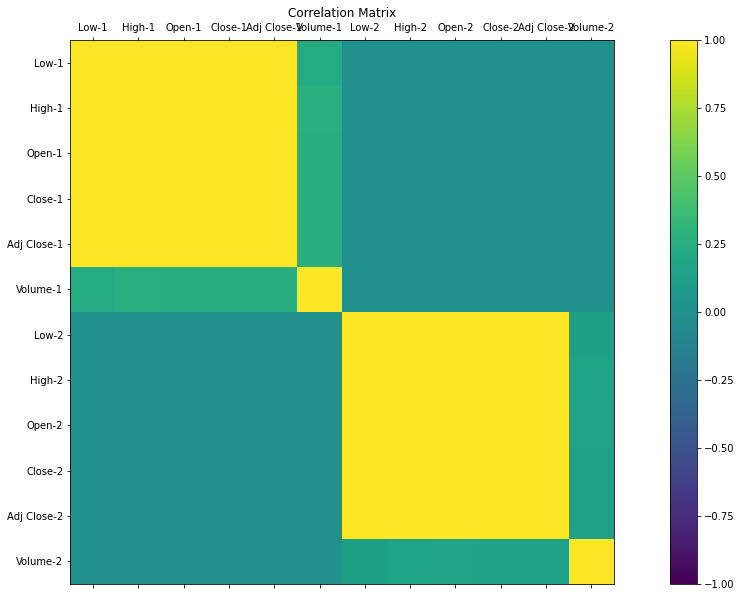

In [11]:
df2 = get_data(another_sck_path, stocksSchema, delimiter=',')
corr_with(df, df2)

In [14]:
def corr_with2(df1, df2):
    df2_pd = df2.toPandas()
    df1_pd = df1.toPandas()
     
    df1_name = df1_pd.iloc[0, -1]
    df2_name = df2_pd.iloc[0, -1]
    
    df1_pd = df1_pd.drop(columns=['Date', 'company_name'])
    df2_pd = df2_pd.drop(columns=['Date', 'company_name'])
    
    cols_1 = df1_pd.columns
    cols_2 = df2_pd.columns
    
    df1_pd[cols_1] = df1_pd[cols_1].apply(pd.to_numeric, errors='coerce', axis=1)
    df2_pd[cols_2] = df2_pd[cols_2].apply(pd.to_numeric, errors='coerce', axis=1)

    new_cols_1 = [col + ' ' + df1_name for col in cols_1]
    new_cols_2 = [col + ' ' + df2_name for col in cols_2]
    df1_pd.columns = new_cols_1
    df2_pd.columns = new_cols_2
    
    df = pd.concat([df1_pd,df2_pd],axis=1)
    corr = df.corr()
    #corr = corr.loc[new_cols_1, new_cols_2]
    
    fig=plt.figure()
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Matrix")
    cax=ax.matshow(corr,vmax=1,vmin=-1)
    ax.set_xticklabels(['']+df.columns, rotation=90, ha='left')
    ax.set_yticklabels(['']+df.columns)
    fig.colorbar(cax)
    #plt.xticks(rotation=90)
    plt.show()

/var/folders/20/t1flkcns5419tjpzt_pg4vv40000gn/T/ipykernel_2120/3925604182.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+df.columns, rotation=90, ha='left')
/var/folders/20/t1flkcns5419tjpzt_pg4vv40000gn/T/ipykernel_2120/3925604182.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+df.columns)


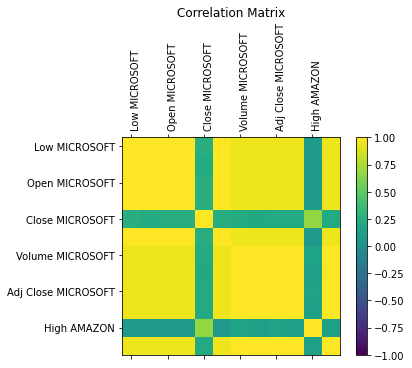

In [15]:
corr_with2(df, df2)